<a href="https://colab.research.google.com/github/opheliaming/deep-learning-v2-pytorch/blob/master/Practical2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from random import shuffle
import re

import urllib.request
import zipfile
import lxml.etree

In [0]:
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [0]:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

In [0]:
def label(x):
  y = []
  for word in ["Technology", "Entertainment", "Design"]:
    y.append(word[0] if word.lower() in x.lower() else 'o')
  return y 

In [0]:
keyword = doc.xpath('//keywords/text()')
keyword_label = [label(x) for x in keyword]
keyword_label = [''.join(x) for x in keyword_label]
input_text = doc.xpath('//content/text()')

In [0]:
sentense_ted_tokens = []
for sent_str in input_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentense_ted_tokens.append(tokens)

In [116]:
from gensim.models import Word2Vec
embed_model = Word2Vec(min_count=1)
embed_model.build_vocab(sentense_ted_tokens)
embed_model.train(sentense_ted_tokens,total_examples=embed_model.corpus_count,epochs=embed_model.epochs)

(16322935, 22462445)

In [0]:
import numpy as np
words_top_vec = [np.mean(embed_model.wv[x], axis=0) for x in sentense_ted_tokens]

In [0]:
unique_labels = set(keyword_label)
label_lookup = dict(zip(sorted(unique_labels), range(len(unique_labels))))

In [0]:
keyword_label_index = [label_lookup[label] for label in keyword_label]

In [0]:
train_set  = list(zip(words_top_vec[:1585], keyword_label_index[:1585]))
validation_set = list(zip(words_top_vec[1585:(1585+250)], keyword_label_index[1585:(1585+250)]))
test_set = list(zip(words_top_vec[(1585+250):(1585+500)], keyword_label_index[(1585+250):(1585+500)]))

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [0]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)
testloader =  torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(100,50)
        self.layer2 = nn.Linear(50,8)
    
    def forward(self, x):     
        x = x.view(x.shape[0], -1) 
        x = nn.Tanh()(self.layer1(x))
        x = F.log_softmax(self.layer2(x),dim=1)
        return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [145]:
epochs = 1000
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for word_vec, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(word_vec)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()       
        running_loss += loss.item()

    validation_loss = 0
    accuracy = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for word_vec, labels in validationloader:
            log_ps = model(word_vec)
            validation_loss += criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

      #train_losses.append(running_loss/len(trainloader))
      #validation_loss.append(validation_loss/len(validationloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}.. ".format(validation_loss/len(validationloader)),
        "Test Accuracy: {:.3f}".format(accuracy/len(validationloader)))
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(validation_loss/len(validationloader))
 #    else:
#        print(f"Training loss: {running_loss/len(trainloader)}")

Epoch: 1/1000..  Training Loss: 0.026..  Test Loss: 5.231..  Test Accuracy: 0.412
Epoch: 2/1000..  Training Loss: 0.027..  Test Loss: 5.419..  Test Accuracy: 0.413
Epoch: 3/1000..  Training Loss: 0.035..  Test Loss: 5.370..  Test Accuracy: 0.407
Epoch: 4/1000..  Training Loss: 0.026..  Test Loss: 5.386..  Test Accuracy: 0.409
Epoch: 5/1000..  Training Loss: 0.031..  Test Loss: 5.628..  Test Accuracy: 0.409
Epoch: 6/1000..  Training Loss: 0.031..  Test Loss: 5.447..  Test Accuracy: 0.404
Epoch: 7/1000..  Training Loss: 0.028..  Test Loss: 5.303..  Test Accuracy: 0.409
Epoch: 8/1000..  Training Loss: 0.024..  Test Loss: 5.255..  Test Accuracy: 0.414
Epoch: 9/1000..  Training Loss: 0.025..  Test Loss: 5.178..  Test Accuracy: 0.423
Epoch: 10/1000..  Training Loss: 0.023..  Test Loss: 5.420..  Test Accuracy: 0.412
Epoch: 11/1000..  Training Loss: 0.024..  Test Loss: 5.245..  Test Accuracy: 0.416
Epoch: 12/1000..  Training Loss: 0.023..  Test Loss: 5.477..  Test Accuracy: 0.412
Epoch: 13/100

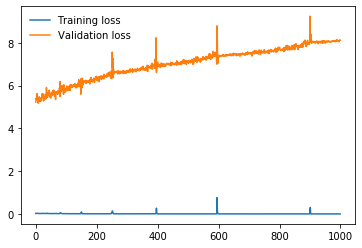

In [146]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)